In [26]:
import os
import random
import shutil
import pathlib
import urllib.request
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from torchvision import transforms, datasets, models
from torchvision.datasets import ImageFolder, OxfordIIITPet
import torchvision.utils
from sklearn.model_selection import train_test_split

### Step 1. Create your custom dataset featuring 3 custom categories of at least 100 images each

In [29]:
# Download the full Oxford-IIIT Pet Dataset (trainval split as a default)
dataset = OxfordIIITPet(root='./data', split='trainval', target_types='category', download=True, transform=None)

# Categoriesincluded 
categories_to_split = ['Beagle', 'Pug', 'Chihuahua']

# class name to index mapping
class_to_idx = dataset.class_to_idx  
print(f"Class mapping: {class_to_idx}")

# Path for saving the filtered dataset
custom_dataset_path = './custom_oxford_pet_dataset/'
os.makedirs(custom_dataset_path, exist_ok=True)

# Function to save images to a filtered dataset
def save_all_images_from_dataset(dataset, categories):
    category_counter = {category: 0 for category in categories}
    
    # Iterate through the dataset
    for i in range(len(dataset)):
        image, target = dataset[i]
        category_name = list(class_to_idx.keys())[list(class_to_idx.values()).index(target)]
        
        if category_name in categories:
            category_path = os.path.join(custom_dataset_path, category_name)
            os.makedirs(category_path, exist_ok=True)

            # Save image to the respective category folder without renaming
            image_path = os.path.join(category_path, f'image_{category_counter[category_name]}.jpg')
            image.save(image_path)

            category_counter[category_name] += 1

save_all_images_from_dataset(dataset, categories=categories_to_split)
print(f"All images from the selected categories have been saved successfully.")

Class mapping: {'Abyssinian': 0, 'American Bulldog': 1, 'American Pit Bull Terrier': 2, 'Basset Hound': 3, 'Beagle': 4, 'Bengal': 5, 'Birman': 6, 'Bombay': 7, 'Boxer': 8, 'British Shorthair': 9, 'Chihuahua': 10, 'Egyptian Mau': 11, 'English Cocker Spaniel': 12, 'English Setter': 13, 'German Shorthaired': 14, 'Great Pyrenees': 15, 'Havanese': 16, 'Japanese Chin': 17, 'Keeshond': 18, 'Leonberger': 19, 'Maine Coon': 20, 'Miniature Pinscher': 21, 'Newfoundland': 22, 'Persian': 23, 'Pomeranian': 24, 'Pug': 25, 'Ragdoll': 26, 'Russian Blue': 27, 'Saint Bernard': 28, 'Samoyed': 29, 'Scottish Terrier': 30, 'Shiba Inu': 31, 'Siamese': 32, 'Sphynx': 33, 'Staffordshire Bull Terrier': 34, 'Wheaten Terrier': 35, 'Yorkshire Terrier': 36}
All images from the selected categories have been saved successfully.


In [30]:
# Get the count of all images in the category folder 
data_dir = pathlib.Path("custom_oxford_pet_dataset")
categories = ['Beagle', 'Pug', 'Chihuahua']
image_counts = {}
for category in categories:
    category_path = data_dir / category
    image_files = list(category_path.glob('*.jpg')) + list(category_path.glob('*.png'))  # Add other formats if needed
    image_counts[category] = len(image_files)

for category, count in image_counts.items():
    print(f"{category}: {count} images")

Beagle: 100 images
Pug: 100 images
Chihuahua: 100 images


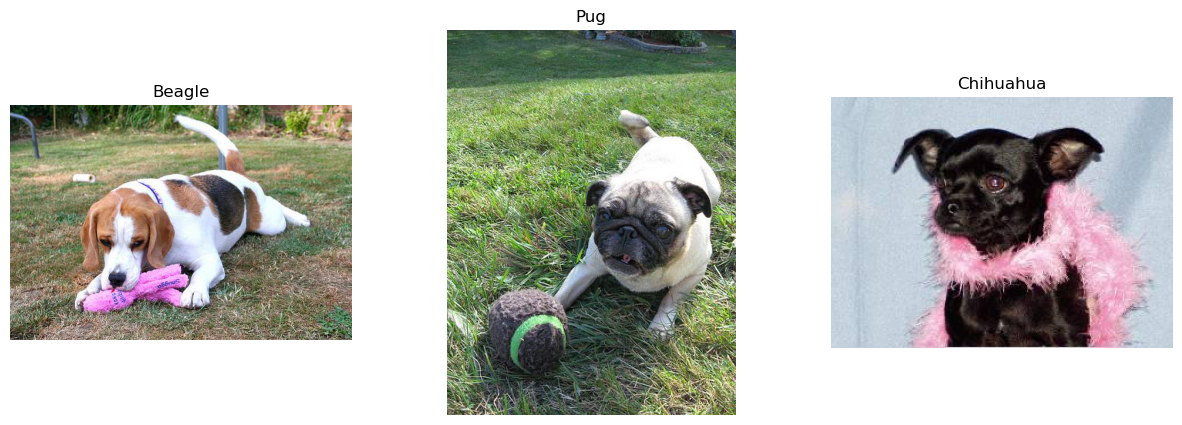

In [33]:
# Set up the plot to display 1 image from each category
plt.figure(figsize=(15, 5))
for i, category in enumerate(categories):
    category_path = data_dir / category
    image_files = list(category_path.glob('*.jpg')) + list(category_path.glob('*.png'))
    if image_files:
        img_path = str(image_files[0])
        img = Image.open(img_path)
        plt.subplot(1, len(categories), i+1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    else:
        print(f"No images found in the {category} category")
plt.show()

#### Used OxfordIIITPet from pyTorch. Here i'm using 3 categories of dog ['Beagle', 'Pug', 'Chihuahua'] and i have download dataset in data directory and filtered only these 3 categories with 100 images each

### Step 2. Preprocess the data as you see fit

In [39]:
img_height, img_width = 224, 224  # or any size you prefer

# Define data augmentation for the training set
train_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Reduce rotation angle
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the test transform without augmentation
test_transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Reduce rotation angle
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(custom_dataset_path, transform=train_transform)
test_dataset = ImageFolder(custom_dataset_path, transform=test_transform)

dataset = ImageFolder(data_dir, transform=train_transform)
class_names = train_dataset.classes
print(class_names)

['Beagle', 'Chihuahua', 'Pug']


Since dataset size is small adding data augumentation to prevent overfit and underfit

#### Images are resized to 256x256, center-cropped to 224x224, converted to tensors, and normalized using ImageNet's mean and standard deviation

### Step 3. Split this data between 80% training and 20% test

In [44]:
train_size = int(0.8 * len(train_dataset))  # 80% for training
test_size = len(train_dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])
print(f"Training set size: {len(train_dataset)} images")
print(f"Test set size: {len(test_dataset)} images")

Training set size: 240 images
Test set size: 60 images


In [46]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


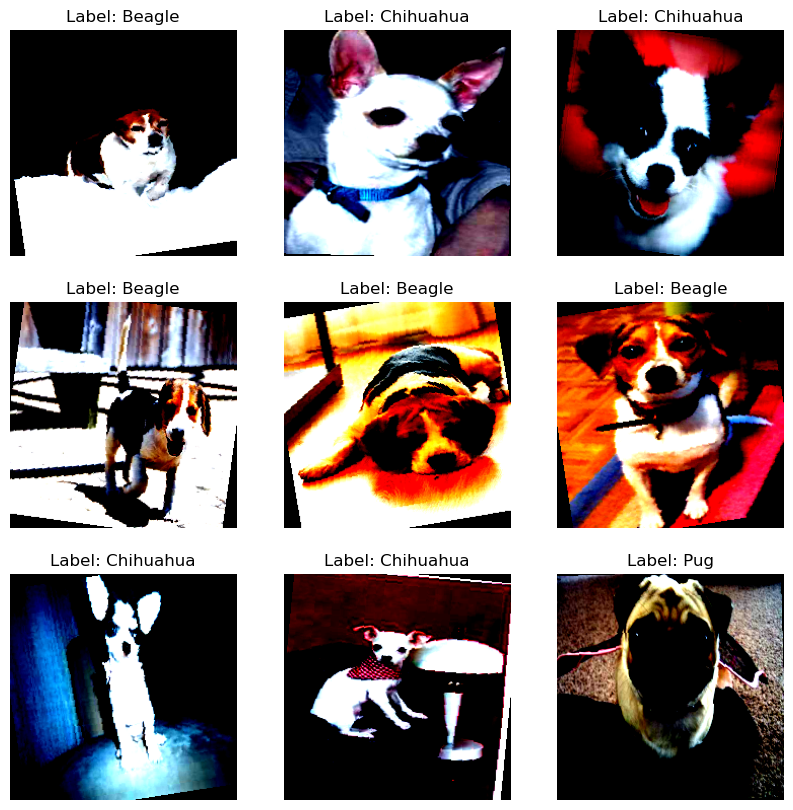

In [48]:
#display images from train data
data_iter = iter(train_dataloader)
images, labels = next(data_iter)
plt.figure(figsize=(10, 10))
for i in range(9):
    image = images[i].permute(1, 2, 0).numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")
plt.show()

#### Dataset is split into 80:20 for train and test . Out of 300 images 240 are train and 60 are test

### Step 4. Create a Convolutional Neural Network model to learn about your training set 

In [52]:
class CNNModel(nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(CNNModel, self).__init__()
        self.rescaling = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (img_height // 8) * (img_width // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescaling(x)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define input dimensions
img_height, img_width = 224, 224
num_classes = 3

# Instantiate the model
model = CNNModel(num_classes, img_height, img_width)

CNN model with 4 convolutional layers followed by two fully connected layers. It uses common techniques like batch normalization, ReLU activation, and data augmentation to improve learning. The final output layer matches the number of classes(3) in the dataset.
- `Conv1`: Takes 3 input channels (RGB) and outputs 16 feature maps with a kernel size of 3x3.
- `Conv2`: Takes 16 input channels and outputs 32 feature maps with a kernel size of 3x3.
- `Conv3`: Takes 32 input channels and outputs 64 feature maps with a kernel size of 3x3.
- `Conv4`: Takes 64 input channels and outputs 128 feature maps with a kernel size of 3x3.
Feature maps are flattened into a 1D vector to be passed into the fully connected layers.
In fully connected layer I have FC1 a linear layer with `128` neurons that processes the flattened feature maps and FC2 a linear output layer that has `3` neurons for final classification.
ReLU activation is used after each convolutional layer and the first fully connected layer to introduce non-linearity.
CrossEntropyLoss as the loss function and Adam optimizer  is used to update the model's weights during training.
- The model is trained over multiple epochs (15).
- Each image batch is passed through data augmentation (`RandomHorizontalFlip` and `RandomRotation`).
- After each forward pass, the loss is computed, gradients are backpropagated, and the optimizer updates the model's weights.
- Accuracy is computed as the proportion of correct predictions for each batch, and the loss/accuracy is printed after each epoch.


In [55]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            data_augmented_inputs = torch.stack([transforms.RandomHorizontalFlip()(img) for img in images])
            data_augmented_inputs = torch.stack([transforms.RandomRotation(degrees=10)(img) for img in data_augmented_inputs])
            optimizer.zero_grad()
            outputs = model(images) 
            loss = criterion(outputs, labels) 
            loss.backward() 
            optimizer.step()
            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)
            train_loss += loss.item() * images.size(0)

        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the model
num_epochs = 15
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/15, Loss: 1.2956, Accuracy: 0.3667
Epoch 2/15, Loss: 1.0998, Accuracy: 0.3458
Epoch 3/15, Loss: 1.0859, Accuracy: 0.3458
Epoch 4/15, Loss: 1.0709, Accuracy: 0.4250
Epoch 5/15, Loss: 0.9926, Accuracy: 0.5083
Epoch 6/15, Loss: 0.9317, Accuracy: 0.5667
Epoch 7/15, Loss: 0.9215, Accuracy: 0.5792
Epoch 8/15, Loss: 0.8821, Accuracy: 0.6375
Epoch 9/15, Loss: 0.8421, Accuracy: 0.5875
Epoch 10/15, Loss: 0.8312, Accuracy: 0.6208
Epoch 11/15, Loss: 0.7510, Accuracy: 0.6792
Epoch 12/15, Loss: 0.6604, Accuracy: 0.7417
Epoch 13/15, Loss: 0.5880, Accuracy: 0.7667
Epoch 14/15, Loss: 0.5153, Accuracy: 0.8042
Epoch 15/15, Loss: 0.4356, Accuracy: 0.8333


### Step 5. Make predictions on the test data and compare them to the expected categories

In [92]:
def predict_and_evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) 
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and actual labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f'Accuracy of the CNN model on the test data: {accuracy:.2f}%')
    return accuracy

cnn_accuracy = predict_and_evaluate(model, test_dataloader)

Accuracy of the CNN model on the test data: 51.67%


#### The model shows steady learning progress with a significant increase in accuracy from 36.67% in epoch 1 to 83.33% in epoch 15 during training. However, there is slight lower generalization on the test set(51.67%).This might be caused due to limited data, overfitting of training but doesn't generalize well to unseen data (test set). We can try to improve accuracy through further tuning or augmentation techniques.

In [95]:
# Load and preprocess the unseen image
image_path = 'custom_oxford_pet_dataset/Beagle/image_17.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

In [97]:
# Perform inference
with torch.no_grad():
    output = model(input_batch)
# Get the predicted class
_, predicted_class = output.max(1)

# Map the predicted class to the class name
class_names = ['Beagle', 'Pug', 'Chihuahua']
predicted_class_name = class_names[predicted_class.item()]

# Calculate probabilities using the output from the model
probabilities = torch.softmax(output, dim=1)
confidence = torch.max(probabilities).item()

print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")

This image most likely belongs to Chihuahua with a 89.05% confidence.


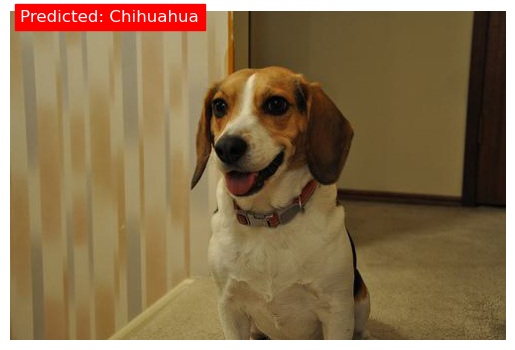

In [99]:
image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

### Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.

In [102]:
googlenet = models.googlenet(pretrained=True)
num_classes = len(dataset.classes) 
googlenet.fc = nn.Linear(googlenet.fc.in_features, num_classes)

if torch.cuda.is_available():
    googlenet = googlenet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer_googlenet = optim.Adam(googlenet.parameters(), lr=0.001)

for epoch in range(5):
    googlenet.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader: 
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer_googlenet.zero_grad()
        outputs = googlenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_googlenet.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_dataloader)}")

/Users/monicalokare/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/monicalokare/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.39638964366167784
Epoch 2, Loss: 0.2121284547029063
Epoch 3, Loss: 0.16279178578406572
Epoch 4, Loss: 0.09236200246959925
Epoch 5, Loss: 0.0772921183379367


### Step 7: Train the GoogleNet model and compare the accuracy with the first model.

In [104]:
googlenet.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_dataloader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = googlenet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy of GoogleNet model: {100 * correct / total:.2f}%")
print(f"Accuracy of the CNN model: {cnn_accuracy:.2f}%")

Test Accuracy of GoogleNet model: 91.67%
Accuracy of the CNN model: 51.67%


#### A custom CNN model and a pre-trained GoogleNet model indicate a significant performance difference between the two with epoch as 5. Test Accuracy of GoogleNet model: 91.67% and Test Accuracy of CNN model: 51.67%.
- The use of a state-of-the-art architecture and transfer learning enables GoogleNet to outperform the custom CNN by a large margin. GoogleNet shows that it can quickly adapt to a new dataset with high accuracy which makes it a highly efficient solution where the computational resources or large datasets are limited.
- The custom CNN will likely need more tuning, a more complex architecture, or additional data augmentation techniques to approach the performance of GoogleNet.